<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/book1/bayes_stats/hbayes_binom_rats_pymc3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We fit a hierarchical beta-binomial model to some count data derived from rat survival. (In the book, we motivate this in terms of covid incidence rates.)
Based on https://docs.pymc.io/notebooks/GLM-hierarchical-binominal-model.html


In [1]:
%matplotlib inline
import sklearn
import scipy.stats as stats
import scipy.optimize
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np
import os
import pandas as pd

In [2]:
# We install various packages  we will need

# The PyMC3 package (https://docs.pymc.io) supports HMC and variational inference
# https://docs.pymc.io/notebooks/api_quickstart.html
#Installed version of ArviZ requires PyMC3>=3.8
!pip install pymc3==3.8
#!pip install pymc3>=3.8 # does not work
import pymc3 as pm
pm.__version__

# The arviz package (https://github.com/arviz-devs/arviz) can be used to make various plots
# of posterior samples generated by any algorithm. 
!pip install arviz
import arviz as az

     |████████████████████████████████| 911kB 6.3MB/s 
     |████████████████████████████████| 1.5MB 17.2MB/s 
     |████████████████████████████████| 737kB 28.5MB/s 
     |████████████████████████████████| 4.7MB 32.0MB/s 
     |████████████████████████████████| 296kB 44.6MB/s 
  Found existing installation: xarray 0.15.1
    Uninstalling xarray-0.15.1:
      Successfully uninstalled xarray-0.15.1
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7


In [3]:



import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
#import seaborn as sns
import pymc3 as pm
import arviz as az
import theano.tensor as tt

In [5]:
np.random.seed(123)




# rat data (BDA3, p. 102)
y = np.array([
    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,
    1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  5,  2,
    5,  3,  2,  7,  7,  3,  3,  2,  9, 10,  4,  4,  4,  4,  4,  4,  4,
    10,  4,  4,  4,  5, 11, 12,  5,  5,  6,  5,  6,  6,  6,  6, 16, 15,
    15,  9,  4
])
n = np.array([
    20, 20, 20, 20, 20, 20, 20, 19, 19, 19, 19, 18, 18, 17, 20, 20, 20,
    20, 19, 19, 18, 18, 25, 24, 23, 20, 20, 20, 20, 20, 20, 10, 49, 19,
    46, 27, 17, 49, 47, 20, 20, 13, 48, 50, 20, 20, 20, 20, 20, 20, 20,
    48, 19, 19, 19, 22, 46, 49, 20, 20, 23, 19, 22, 20, 20, 20, 52, 46,
    47, 24, 14
])

N = len(n)

In [6]:

def logp_ab(value):
    ''' prior density'''
    return tt.log(tt.pow(tt.sum(value), -5/2))


with pm.Model() as model:
    # Uninformative prior for alpha and beta
    ab = pm.HalfFlat('ab',
                     shape=2,
                     testval=np.asarray([1., 1.]))
    pm.Potential('p(a, b)', logp_ab(ab))
    alpha = pm.Deterministic('alpha', ab[0])
    beta = pm.Deterministic('beta', ab[1])
    X = pm.Deterministic('X', tt.log(ab[0]/ab[1]))
    Z = pm.Deterministic('Z', tt.log(tt.sum(ab)))

    theta = pm.Beta('theta', alpha=ab[0], beta=ab[1], shape=N)

    p = pm.Binomial('y', p=theta, observed=y, n=n)
    #trace = pm.sample(1000, tune=2000, target_accept=0.95)
    trace = pm.sample(1000, tune=500)
    
    
#az.plot_trace(trace)
#plt.savefig('../figures/hbayes_binom_rats_trace.png', dpi=300)

print(az.summary(trace))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, ab]
Sampling chain 1, 0 divergences: 100%|██████████| 1500/1500 [00:05<00:00, 295.21it/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


             mean     sd  hdi_3%  hdi_97%  ...  ess_sd  ess_bulk  ess_tail  r_hat
ab[0]       2.414  0.888   1.167    4.106  ...   248.0     345.0     355.0    1.0
ab[1]      14.364  5.189   6.021   23.942  ...   281.0     339.0     368.0    1.0
alpha       2.414  0.888   1.167    4.106  ...   248.0     345.0     355.0    1.0
beta       14.364  5.189   6.021   23.942  ...   281.0     339.0     368.0    1.0
X          -1.783  0.108  -1.976   -1.568  ...  1505.0    1539.0    1578.0    1.0
...           ...    ...     ...      ...  ...     ...       ...       ...    ...
theta[66]   0.269  0.054   0.178    0.377  ...  2170.0    2224.0    1407.0    1.0
theta[67]   0.281  0.060   0.164    0.382  ...  2148.0    2573.0    1264.0    1.0
theta[68]   0.274  0.056   0.173    0.379  ...  2222.0    2536.0    1529.0    1.0
theta[69]   0.285  0.074   0.149    0.428  ...  1728.0    1870.0    1341.0    1.0
theta[70]   0.210  0.070   0.084    0.337  ...  2573.0    2580.0    1524.0    1.0

[77 rows x 11 c

post mean
[0.06460666 0.06437104 0.06465235 0.06328642 0.06497395 0.06381172
 0.06396174 0.06620239 0.06565401 0.06497806 0.06634617 0.06823599
 0.06735729 0.07041575 0.09191673 0.09123215 0.09220426 0.09201827
 0.0944219  0.09479405 0.09708843 0.09704783 0.10514783 0.10702142
 0.11096465 0.12080444 0.12159981 0.11924594 0.1204072  0.11811501
 0.12011536 0.12502127 0.11257819 0.12459977 0.11717884 0.12342068
 0.13030867 0.14331853 0.14811196 0.1461921  0.14534689 0.14868985
 0.17704337 0.18583653 0.17484847 0.17530343 0.17512519 0.17494787
 0.17485723 0.17697513 0.17598589 0.19192037 0.18088651 0.18249438
 0.17778463 0.19408181 0.2151015  0.22005816 0.2056253  0.2033249
 0.21244499 0.20701786 0.2195349  0.23247886 0.23209864 0.23068479
 0.26883165 0.28102844 0.27380243 0.28470253 0.20954845]
hyper mean
0.14387861410180233
pooled mle
0.1535365152386429


/usr/local/lib/python3.6/dist-packages/arviz/utils.py:661: UserWarning: Keyword argument credible_interval has been deprecated Please replace with hdi_prob
  ("Keyword argument credible_interval has been deprecated " "Please replace with hdi_prob"),
/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


Text(0.5, 1.0, 'posterior mean (red line = hparam)')

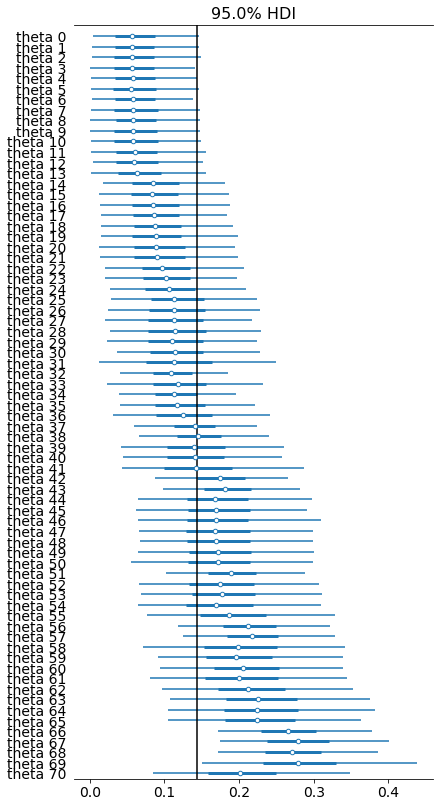

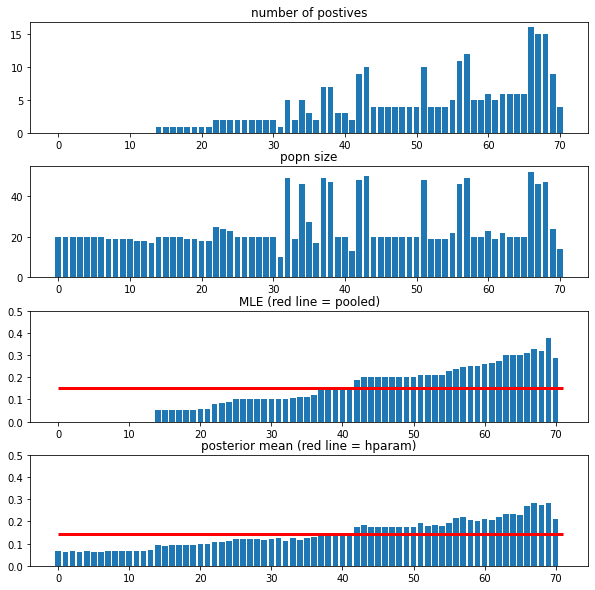

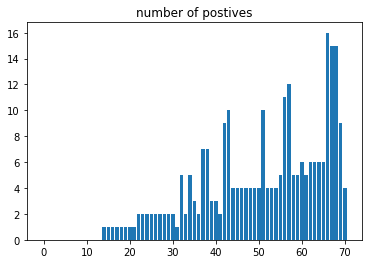

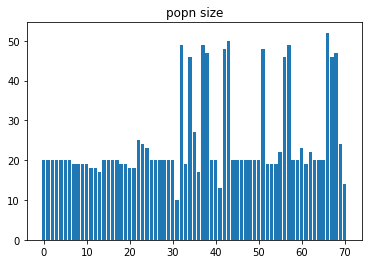

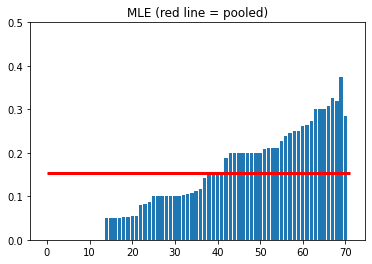

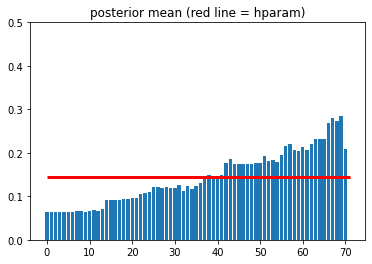

In [9]:

J = len(n)
post_mean = np.zeros(J)
samples = trace[theta]
post_mean = np.mean(samples, axis=0)
print('post mean')
print(post_mean)

alphas = trace['alpha']
betas = trace['beta']
alpha_mean = np.mean(alphas)
beta_mean = np.mean(betas)
hyper_mean = alpha_mean/(alpha_mean + beta_mean)
print('hyper mean')
print(hyper_mean)


mle = y / n
pooled_mle = np.sum(y) / np.sum(n)

print('pooled mle')
print(pooled_mle)


axes = az.plot_forest(
    trace, var_names='theta', credible_interval=0.95, combined=True, colors='cycle')
y_lims = axes[0].get_ylim()
axes[0].vlines(hyper_mean, *y_lims)
#plt.savefig('../figures/hbayes_binom_rats_forest95.pdf', dpi=300)


J = len(n)
fig, axs = plt.subplots(4,1, figsize=(10,10))
plt.subplots_adjust(hspace=0.3)
axs = np.reshape(axs, 4)
xs = np.arange(J)
ax = axs[0]
ax.bar(xs, y)
ax.set_title('number of postives')
ax = axs[1]
ax.bar(xs, n)
ax.set_title('popn size')
ax = axs[2]
ax.bar(xs, mle)
ax.set_ylim(0, 0.5)
ax.hlines(pooled_mle, 0, J, 'r', lw=3)
ax.set_title('MLE (red line = pooled)')
ax = axs[3]
ax.bar(xs, post_mean)
ax.hlines(hyper_mean, 0, J, 'r', lw=3)
ax.set_ylim(0, 0.5)
ax.set_title('posterior mean (red line = hparam)')
#plt.savefig('../figures/hbayes_binom_rats_barplot.pdf', dpi=300)


J = len(n)
xs = np.arange(J)
fig, ax = plt.subplots(1,1)
ax.bar(xs, y)
ax.set_title('number of postives')
#plt.savefig('../figures/hbayes_binom_rats_outcomes.pdf', dpi=300)

fig, ax = plt.subplots(1,1)
ax.bar(xs, n)
ax.set_title('popn size')
#plt.savefig('../figures/hbayes_binom_rats_popsize.pdf', dpi=300)

fig, ax = plt.subplots(1,1)
ax.bar(xs, mle)
ax.set_ylim(0, 0.5)
ax.hlines(pooled_mle, 0, J, 'r', lw=3)
ax.set_title('MLE (red line = pooled)')
#plt.savefig('../figures/hbayes_binom_rats_MLE.pdf', dpi=300)

fig, ax = plt.subplots(1,1)
ax.bar(xs, post_mean)
ax.hlines(hyper_mean, 0, J, 'r', lw=3)
ax.set_ylim(0, 0.5)
ax.set_title('posterior mean (red line = hparam)')
#plt.savefig('../figures/hbayes_binom_rats_postmean.pdf', dpi=300)
